# Telegram channel message data analysis

In [3]:
import json
import pandas as pd
import re
import requests

from bs4 import BeautifulSoup
from glob import glob

## Load message data from json files

Let's loop through all available files and concatenate
their values into a single dataframe.

In [4]:
json_files = glob("*-messages.json")

In [5]:
def grab_wanted_object_properties(parsed_json):
    wanted_props = {
        "message_id": parsed_json['id'],
        "date": parsed_json['date'],
    }
    wanted_props["message"] = parsed_json['message'] if "message" in parsed_json else None
    return wanted_props

In [6]:
formatted_list = []
for file in json_files:
    with open(file, 'r') as json_file:
        loaded_file = json.load(json_file)
    for obj in loaded_file:
        formatted_list.append(grab_wanted_object_properties(obj))

In [7]:
df = pd.DataFrame(formatted_list)

In [8]:
df.head()

,message_id,date,message
0,66952,2023-03-24 15:27:48+00:00,Acho que vc não sabe o que realmente é orienta...
1,66951,2023-03-24 15:22:02+00:00,"Se tu muda um atributo de qualquer coisa, tu t..."
2,66950,2023-03-24 15:21:35+00:00,Toda vez que tu cria uma variável ou muda o ti...
3,66949,2023-03-24 15:14:15+00:00,E existe uma diferença tbm de saber a sintaxe ...
4,66948,2023-03-24 15:12:27+00:00,Vc consegue passar a vida programando de manei...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   message_id  200 non-null    int64 
 1   date        200 non-null    object
 2   message     198 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


In [10]:
df.dtypes

message_id     int64
date          object
message       object
dtype: object

## Finding messages with youtube URLs

This can be done by using a regular expression.

In [11]:
def find_youtube_url(message):
    if message is None:
        return None
    rgx = re.search(
        "(?:https?:\/\/)?(?:m\.)?(?:www\.)?youtu\.?be(?:\.com)?\/?\S*(?:watch|embed)?(?:\S*v=|v\/|\/)([\w\-]+)(?:[\&\?]?([\w\-]+)?=?([\w\%\-]+)?)+",
        message
    )
    return rgx.group(0) if rgx is not None else None

In [12]:
test_1 = find_youtube_url("Essa música aqui que é boa: https://www.youtube.com/watch?v=SOJSM46nWwo")
print(f"Encontrado: {test_1}")
test_2 = find_youtube_url("Essa mensagem não tem nenhuma url do youtube!")
print(f"Encontrado: {test_2}")

Encontrado: https://www.youtube.com/watch?v=SOJSM46nWwo
Encontrado: None


### Creating a new DataFrame column

This new column will contain only the youtube url parsed from the message.

In [13]:
df['youtube_url'] = df['message'].apply(find_youtube_url)

In [14]:
df_ytb_urls = df.dropna()
df_ytb_urls.head()

,message_id,date,message,youtube_url
16,66936,2023-03-24 04:38:18+00:00,https://youtu.be/14hvcjeXsFE,https://youtu.be/14hvcjeXsFE
17,66935,2023-03-24 04:33:41+00:00,https://youtu.be/AcHHE9bvLgY,https://youtu.be/AcHHE9bvLgY
18,66934,2023-03-24 04:25:41+00:00,https://youtu.be/wJl0fpUc4U8,https://youtu.be/wJl0fpUc4U8
33,66917,2023-03-24 03:55:39+00:00,https://youtu.be/kbDrJ16A2Iw,https://youtu.be/kbDrJ16A2Iw
38,66912,2023-03-24 00:21:21+00:00,https://youtu.be/hDtkm1Mnwlg,https://youtu.be/hDtkm1Mnwlg


In [15]:
len(df_ytb_urls)

32

# Getting youtube video information from the oembed API

Youtube has an open endpoint that can be used to validate URLs and get general information about a video.

In [80]:
video_url = "https://youtu.be/14hvcjeXsFE"
oembed_url = f"https://www.youtube.com/oembed?url={video_url}&format=json"
response = requests.get(oembed_url)
print(response.status_code)
print(response.json())

200
{'title': 'Black Pantera - Rede Social', 'author_name': 'Black Pantera', 'author_url': 'https://www.youtube.com/@BlackPanteraOficial', 'type': 'video', 'height': 113, 'width': 200, 'version': '1.0', 'provider_name': 'YouTube', 'provider_url': 'https://www.youtube.com/', 'thumbnail_height': 360, 'thumbnail_width': 480, 'thumbnail_url': 'https://i.ytimg.com/vi/14hvcjeXsFE/hqdefault.jpg', 'html': '<iframe width="200" height="113" src="https://www.youtube.com/embed/14hvcjeXsFE?feature=oembed" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen title="Black Pantera - Rede Social"></iframe>'}


## Videos have a "author_name" field

In the following format: `'author_name': 'Gaia Piá - Topic'`, the "Topic" might represent that it is from a band.

In [82]:
video_url = "https://youtu.be/14hvcjeXsFE"
oembed_url = f"https://www.youtube.com/oembed?url={video_url}&format=json"
response = requests.get(oembed_url)
print(f"Response status: {response.status_code}")
ytb_json = response.json()
print(f"Youtube oembed json: {ytb_json}")

Response status: 200
Youtube oembed json: {'title': 'Black Pantera - Rede Social', 'author_name': 'Black Pantera', 'author_url': 'https://www.youtube.com/@BlackPanteraOficial', 'type': 'video', 'height': 113, 'width': 200, 'version': '1.0', 'provider_name': 'YouTube', 'provider_url': 'https://www.youtube.com/', 'thumbnail_height': 360, 'thumbnail_width': 480, 'thumbnail_url': 'https://i.ytimg.com/vi/14hvcjeXsFE/hqdefault.jpg', 'html': '<iframe width="200" height="113" src="https://www.youtube.com/embed/14hvcjeXsFE?feature=oembed" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen title="Black Pantera - Rede Social"></iframe>'}


## Getting band/author information

We have a few options on how to use a given author name to grab genre information.

- Spotify API: <https://developer.spotify.com/documentation/web-api/>
- EveryNoise: <https://everynoise.com/>

The everynoise website doesn't have an actual API endpoint, but we can leverage it's lookup url and parse the HTML.

In [83]:
ytb_author = ytb_json['author_name']
ytb_title = ytb_json['title']

print(f"Received author from youtube oembed: {ytb_author}")
print(f"Received title from youtube oembed: {ytb_title}")

Received author from youtube oembed: Black Pantera
Received title from youtube oembed: Black Pantera - Rede Social


## Using the everynoise search URL

Let's start by sending the `ytb_author` string directly and trying to parse the output

In [84]:
everynoise_url = "https://everynoise.com/lookup.cgi"

In [85]:
everynoise_request = requests.get(everynoise_url, params={"who": ytb_author})

In [86]:
everynoise_request.text

'<html>\n<head>\n<meta http-equiv="Content-Type" content="text/html;charset=utf-8">\n<style type="text/css">\nbody {font: 14px "Gill Sans", "Gill Sans MT", "Trebuchet MS", sans-serif; margin: 0px; color: gray}\nform {display: inline}\na {color: teal; text-decoration: none}\na:hover {color: red; text-decoration: underline}\n</style>\n<body>\n\n<form action="lookup.cgi" method="GET">find artist <input type=text size=52 name=who value="Black Pantera"><input type=hidden name=mode value="map"></form>\n<div>\n<a href="engenremap-brazilianmetal.html" target=_parent>brazilian metal</a>, <a href="engenremap-brazilianhardcore.html" target=_parent>brazilian hardcore</a>, <a href="engenremap-brazilianposthardcore.html" target=_parent>brazilian post-hardcore</a>, <a href="engenremap-brazilianrock.html" target=_parent>brazilian rock</a>\n&nbsp; <a href="everynoise1d.cgi?scope=all&root=brazilian%20metal&root=brazilian%20hardcore&root=brazilian%20post-hardcore&root=brazilian%20rock" target=_parent tit

Since this requests returns valid html, we can parse it with beautiful soup.

In [87]:
soup = BeautifulSoup(everynoise_request.text, 'html.parser')
soup.prettify()


'<html>\n <head>\n  <meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>\n  <style type="text/css">\n   body {font: 14px "Gill Sans", "Gill Sans MT", "Trebuchet MS", sans-serif; margin: 0px; color: gray}\nform {display: inline}\na {color: teal; text-decoration: none}\na:hover {color: red; text-decoration: underline}\n  </style>\n  <body>\n   <form action="lookup.cgi" method="GET">\n    find artist\n    <input name="who" size="52" type="text" value="Black Pantera"/>\n    <input name="mode" type="hidden" value="map"/>\n   </form>\n   <div>\n    <a href="engenremap-brazilianmetal.html" target="_parent">\n     brazilian metal\n    </a>\n    ,\n    <a href="engenremap-brazilianhardcore.html" target="_parent">\n     brazilian hardcore\n    </a>\n    ,\n    <a href="engenremap-brazilianposthardcore.html" target="_parent">\n     brazilian post-hardcore\n    </a>\n    ,\n    <a href="engenremap-brazilianrock.html" target="_parent">\n     brazilian rock\n    </a>\n    <a href="eve

In [88]:
soup.find_all('div')

[<div>
 <a href="engenremap-brazilianmetal.html" target="_parent">brazilian metal</a>, <a href="engenremap-brazilianhardcore.html" target="_parent">brazilian hardcore</a>, <a href="engenremap-brazilianposthardcore.html" target="_parent">brazilian post-hardcore</a>, <a href="engenremap-brazilianrock.html" target="_parent">brazilian rock</a>
   <a href="everynoise1d.cgi?scope=all&amp;root=brazilian%20metal&amp;root=brazilian%20hardcore&amp;root=brazilian%20post-hardcore&amp;root=brazilian%20rock" target="_parent" title="go to the list view for these genres">â·</a>
   <a href="artistprofile.cgi?id=2PftOgEPewb4XsaeE4567t" target="_parent" title="go to the profile for this artist">â</a>
 </div>]

In [89]:
soup.find_all('a')

[<a href="engenremap-brazilianmetal.html" target="_parent">brazilian metal</a>,
 <a href="engenremap-brazilianhardcore.html" target="_parent">brazilian hardcore</a>,
 <a href="engenremap-brazilianposthardcore.html" target="_parent">brazilian post-hardcore</a>,
 <a href="engenremap-brazilianrock.html" target="_parent">brazilian rock</a>,
 <a href="everynoise1d.cgi?scope=all&amp;root=brazilian%20metal&amp;root=brazilian%20hardcore&amp;root=brazilian%20post-hardcore&amp;root=brazilian%20rock" target="_parent" title="go to the list view for these genres">â·</a>,
 <a href="artistprofile.cgi?id=2PftOgEPewb4XsaeE4567t" target="_parent" title="go to the profile for this artist">â</a>]

We can try splitting the youtube author by words, and sending them individually

In [25]:
results = []
for word in ytb_author.split(" "):
    everynoise_request = requests.get(everynoise_url, params={"who": word})
    soup = BeautifulSoup(everynoise_request.text, 'html.parser')
    results.append(soup.find_all('a'))
results

[[<a href="engenremap-metal.html" target="_parent">metal</a>,
  <a href="engenremap-hardrock.html" target="_parent">hard rock</a>,
  <a href="engenremap-speedmetal.html" target="_parent">speed metal</a>,
  <a href="engenremap-rock.html" target="_parent">rock</a>,
  <a href="engenremap-albumrock.html" target="_parent">album rock</a>,
  <a href="everynoise1d.cgi?scope=all&amp;root=metal&amp;root=hard%20rock&amp;root=speed%20metal&amp;root=rock&amp;root=album%20rock" target="_parent" title="go to the list view for these genres">â·</a>,
  <a href="artistprofile.cgi?id=1DFr97A9HnbV3SKTJFu62M" target="_parent" title="go to the profile for this artist">â</a>],
 []]

In [90]:
for result in results:
    for link in result:
        print(link.text)

metal
hard rock
speed metal
rock
album rock
â·
â


## Using the Spotify API

Let's try hitting the spotify search endpoint with the values received from the youtube oembed endpoint.

In order to do this, you will have to create a spotify API application on <https://developer.spotify.com/dashboard> and save your Client ID and Client Secret as `SPOTIFY_CLIENT_ID` and `SPOTIFY_CLIENT_SECRET` on the .env file on the root of the repository.

In [91]:
import decouple
from decouple import config

# fix for using decouple with jupyter notebook, see https://github.com/HBNetwork/python-decouple/issues/116
config = decouple.AutoConfig(' ')
SPOTIFY_CLIENT_ID = config("SPOTIFY_CLIENT_ID")
SPOTIFY_CLIENT_SECRET = config("SPOTIFY_CLIENT_SECRET")

### Getting the Access Token

We need to send our credentials in a basic auth header (using base64 encoding).

For more information, see <https://developer.spotify.com/documentation/general/guides/authorization/client-credentials/>

In [92]:
import base64

auth_str = f"{SPOTIFY_CLIENT_ID}:{SPOTIFY_CLIENT_SECRET}"
base64_auth = base64.b64encode(auth_str.encode("ascii")).decode("ascii")
auth_req = requests.post(
    "https://accounts.spotify.com/api/token",
    headers={
        "Authorization": f"Basic {base64_auth}",
        "Content-Type": "application/x-www-form-urlencoded"
    },
    data={"grant_type": "client_credentials"}
)

In [93]:
auth_resp = auth_req.json()

In [94]:
SPOTIFY_BEARER_TOKEN = auth_resp['access_token']

### Accessing the search endpoint

You need to pass the received `access_token` as a Bearer Token in an `Authorization: Bearer ...` header.

For more details on the endpoint, see <https://developer.spotify.com/documentation/web-api/reference/#/operations/search>

In [95]:
ytb_author

'Black Pantera'

In [96]:
search_req = requests.get(
    "https://api.spotify.com/v1/search",
    params={
        "type": "artist",
        "q": ytb_author,
    },
    headers={
        "Content-Type": "application/json",
        "Authorization": f"Bearer {SPOTIFY_BEARER_TOKEN}"
    }
)

In [97]:
search_resp = search_req.json()

In [98]:
result = search_resp['artists']['items'][0]
result

{'external_urls': {'spotify': 'https://open.spotify.com/artist/2PftOgEPewb4XsaeE4567t'},
 'followers': {'href': None, 'total': 17799},
 'genres': ['brazilian hardcore',
  'brazilian metal',
  'brazilian post-hardcore',
  'brazilian rock'],
 'href': 'https://api.spotify.com/v1/artists/2PftOgEPewb4XsaeE4567t',
 'id': '2PftOgEPewb4XsaeE4567t',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6761610000e5eb842f06de64b3c8b533892b83',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ab67616100005174842f06de64b3c8b533892b83',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/ab6761610000f178842f06de64b3c8b533892b83',
   'width': 160}],
 'name': 'Black Pantera',
 'popularity': 29,
 'type': 'artist',
 'uri': 'spotify:artist:2PftOgEPewb4XsaeE4567t'}

In [99]:
artist_name = result['name']
genres = result['genres']
spotify_artist_id = result['id']
artist_images = result['images']

In [76]:
!pip install matplotlib opencv-python -q

Found artist: Black Pantera
Genres: ['brazilian hardcore', 'brazilian metal', 'brazilian post-hardcore', 'brazilian rock']
Spotify id: 2PftOgEPewb4XsaeE4567t


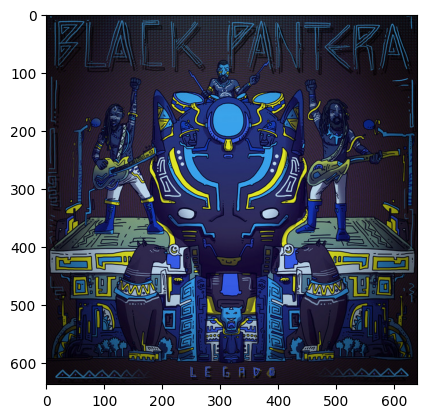

In [100]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



print(f"Found artist: {artist_name}")
print(f"Genres: {genres}")
print(f"Spotify id: {spotify_artist_id}")
if len(artist_images) > 0:
    r = requests.get(artist_images[0]["url"], allow_redirects=True)
    with open('artist_img.png', 'wb') as img_file:
        img_file.write(r.content)
        
    img = cv.imread("artist_img.png")
    plt.imshow(img)
    plt.show()